In [1]:
#base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random

from sklearn.decomposition import PCA
from scipy.spatial import distance
import skbio
from sklearn.preprocessing import MinMaxScaler

In [145]:
#raw data
df = pd.read_csv('input_for_ae/filtered_data.csv', index_col = [0])

In [146]:
#latent layer
latent_df = pd.read_csv('improve_latent/relu_filtered_data.csv',
                        sep = '\t',
                        index_col = [0]
                       )

## calculate alpha diversity for each timepoint in raw data

In [155]:
SHANNON = []
OTUs = []
IDX = []
for idx in df.index:
    shannon = skbio.diversity.alpha.shannon(df.loc[idx].values)
    SHANNON.append(shannon)
    IDX.append(idx)
    
ALPHA_DF = pd.DataFrame(list(zip(IDX, SHANNON, OTUs)), columns = ['idx', 'shannon_diversity'])

# PCA

In [148]:
def calculate_pca(df):
    
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df.values)

    pca = PCA(n_components=32)
    pca.fit(scaled_df)
    #explained variance
    exp_ratio = pd.DataFrame(pca.explained_variance_ratio_, columns = ['perc_exp_variance'])
    variance = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2]
    exp_var = round(variance, 2)
    
    #pca components
    pca_components = pca.transform(scaled_df)
    pca_df = pd.DataFrame(pca_components, columns = ['PC' + str(i) for i in range(1, 33)])
    pca_df['timestep'] = df.index
    
    return exp_var, pca_df

var, pca_df = calculate_pca(df)    

# PCA - plot points characteristics

In [149]:
def plot_pca_timestep(variance, pca_df, title):
    
    plt.figure(figsize = [5, 5])
    
    ax = sns.scatterplot(
        x = 'PC1',
        y = 'PC2',
        data = pca_df,
        hue = 'timestep',
        alpha = .8,
        s = 120
    )
    
    ax.legend(bbox_to_anchor=(1.3, 1))
    
    plt.title('Timestep. Variance explained by 3 components = {}'.format(round(variance, 2)))
    plt.savefig('timesteps_{}.png'.format(title))
    plt.show()

In [150]:
def plot_pca_shannon(variance, pca_df, title):
    
    pca_df['shannon_diversity'] = ALPHA_DF['shannon_diversity']
    pca_df['observed_otus'] = ALPHA_DF['observed_otus']

    
    plt.figure(figsize = [5, 5])
    
    ax = sns.scatterplot(
        x = 'PC1',
        y = 'PC2',
        data = pca_df,
        hue = 'shannon_diversity',
        alpha = .8,
        s = 120
    )
    
    ax.legend(bbox_to_anchor=(1.3, 1))
    
    plt.title('Shannon diversity. Variance explained by 3 components = {}'.format(round(variance, 2)))
    
    plt.savefig('shannon_div_{}.png'.format(title))
    plt.show()

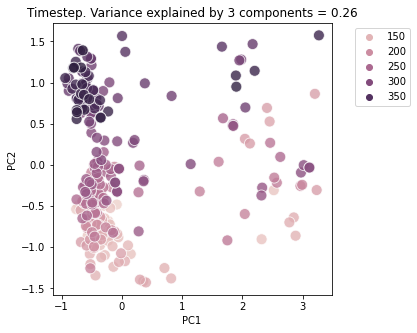

In [151]:
plot_pca_timestep(calculate_pca(df)[0], calculate_pca(df)[1], 'raw')

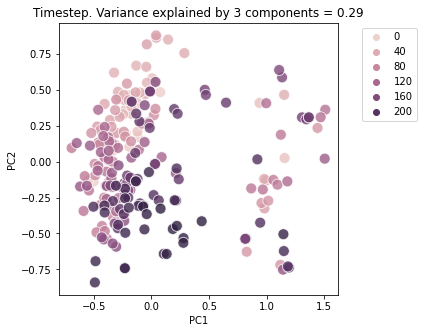

In [152]:
plot_pca_timestep(calculate_pca(latent_df)[0], calculate_pca(latent_df)[1], 'latent')

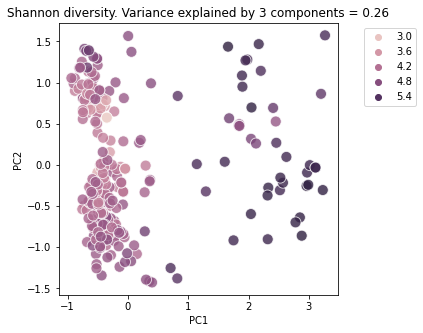

In [153]:
plot_pca_shannon(calculate_pca(df)[0], calculate_pca(df)[1], 'raw')

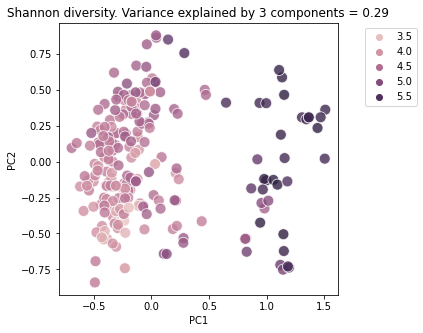

In [154]:
plot_pca_shannon(calculate_pca(latent_df)[0], calculate_pca(latent_df)[1], 'latent')

# PCA - plot points ordination

In [122]:
#tru data (20, 1235)

history_df = pd.read_csv('improve_latent/raw_history.csv',
                      index_col = [0]
                     )
history_df = history_df.tail(20)

#encoded for svar (20, 128)

latent_df = pd.read_csv('improve_latent/encoded_for_svar.csv',
                        sep = '\t',
                        index_col= [0]
                       )
latent_df = latent_df.tail(20)

#reconstruction of raw data by autoencoder

ae_reconstruction_df = pd.read_csv('improve_latent/raw_reconstruction.csv',
                             index_col = [0]
                            )
ae_reconstruction_df = ae_reconstruction_df.tail(20)

#encoded svar prediction (20, 128)

encoded_svar_prediction_df = pd.read_csv('improve_latent/svar_prediction.csv')

#decoded prediction (20, 1235)

decoded_svar_prediction_df = pd.read_csv('improve_latent/decoded_prediction.csv',
                                   index_col = [0]
                                  )

#### plot PCA on true and svar predicted embeddings

In [123]:
def plot_pca_on_embedding_data(raw_embedding, svar_embeding):
    
    ''' 
    @gt_df - df with ground truth data
    @df - df with data that we want to compare with ground truth
    '''
    
    #scale ground truth data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(raw_embedding.values)
    
    #pca on ground truth
    pca = PCA(n_components=5)
    pca.fit_transform(scaled_data)
    
    #pca ocmponents of raw data embedding
    pca_components_true = pca.transform(scaled_data)
    pca_components_true_df = pd.DataFrame(pca_components_true, columns = ['PC' + str(i) for i in range(1, 6)])
    pca_components_true_df['time'] = raw_embedding.index
    
    #scale tested data
    scaler_test = MinMaxScaler()
    scaled_test_data = scaler_test.fit_transform(svar_embeding.values)
    
    #pca on tested data
    pca_components_test = pca.transform(scaled_test_data)
    pca_components_test_df = pd.DataFrame(pca_components_test, columns = ['PC' + str(i) for i in range(1, 6)])
    pca_components_test_df['time'] = raw_embedding.index
    
    return pca_components_true_df, pca_components_test_df

In [124]:
raw_embedding_pca, svar_embedding_pca = plot_pca_on_embedding_data(latent_df, encoded_svar_prediction_df)

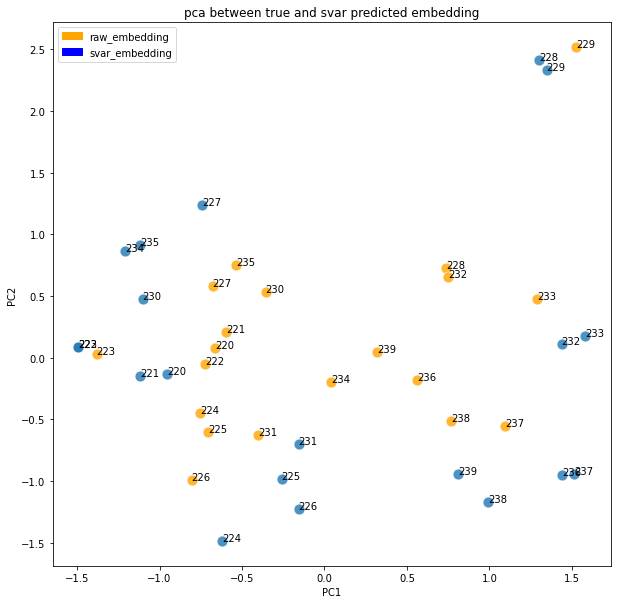

In [132]:
plt.figure(figsize = [10, 10])
###svar
ax = sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = raw_embedding_pca,
    s = 120,
    alpha = .8
)

n = raw_embedding_pca['time']
z = raw_embedding_pca['PC1']
y =  raw_embedding_pca['PC2']

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
    
####latent
ax = sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = svar_embedding_pca,
    s = 120,
    alpha = .8,
    color = 'Orange'
)

n1 = svar_embedding_pca['time']
z1 = svar_embedding_pca['PC1']
y1 =  svar_embedding_pca['PC2']

for i, txt in enumerate(n1):
    ax.annotate(txt, (z1[i], y1[i]))
    
yellow_patch = mpatches.Patch(color='orange', label='raw_embedding')
blue_patch = mpatches.Patch(color='blue', label='svar_embedding')

plt.legend(handles=[yellow_patch, blue_patch])

plt.title('pca between true and svar predicted embedding')
plt.savefig('pca_between_true_and_svar_predicted_embedding.png')

#### plot PCA on true, encoded and decoded prediction data

In [97]:
def plot_ground_truth_pca(gt_df):
    
    ''' 
    @gt_df - df with ground truth data
    '''
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(gt_df.values)
    
    #pca on ground truth
    pca_true = PCA(n_components=5)
    pca_components_true = pca.fit_transform(scaled_data)
    pca_components_true_df = pd.DataFrame(pca_components_true, columns = ['PC' + str(i) for i in range(1, 6)])
    pca_components_true_df['time'] = gt_df.index
    
    return pca_components_true_df

In [127]:
def plot_pca_on_tested_data(gt_df, df):
    
    ''' 
    @gt_df - df with ground truth data
    @df - df withdata that we want to compare with ground truth
    '''
    #scale ground truth data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(gt_df.values)
    
    #pca on ground truth
    pca = PCA(n_components=5)
    pca.fit_transform(scaled_data)
    
    #scale tested data
    scaler_test = MinMaxScaler()
    scaled_test_data = scaler_test.fit_transform(df.values)
    
    #pca on tested data
    pca_components_test = pca.transform(scaled_test_data)
    pca_components_test_df = pd.DataFrame(pca_components_test, columns = ['PC' + str(i) for i in range(1, 6)])
    pca_components_test_df['time'] = gt_df.index
    
    return pca_components_test_df

In [128]:
#history pca
history_pca_df = plot_ground_truth_pca(history_df)
#encoded data 
encoded_pca_df = plot_pca_on_tested_data(history_df, ae_reconstruction_df)
#decoded svar prediction
pred_pca_df = plot_pca_on_tested_data(history_df, decoded_svar_prediction_df)

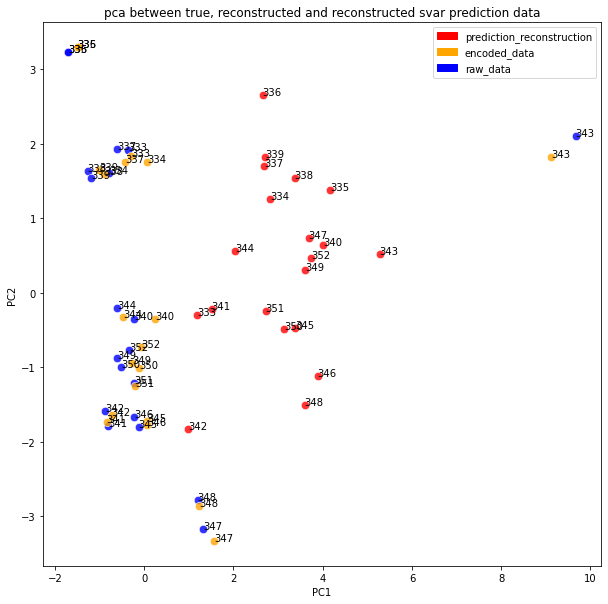

In [133]:
plt.figure(figsize = [10, 10])
###ground t
ax = sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = history_pca_df,
    s = 70,
    alpha = .8,
    color = 'Blue'
)

n = history_pca_df['time']
z = history_pca_df['PC1']
y =  history_pca_df['PC2']

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
    
#### encoded pca
ax = sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = encoded_pca_df,
    s = 70,
    alpha = .8,
    color = 'Orange'
)

n1 = encoded_pca_df['time']
z1 = encoded_pca_df['PC1']
y1 =  encoded_pca_df['PC2']

for i, txt in enumerate(n1):
    ax.annotate(txt, (z1[i], y1[i]))
    
#### decoded svar prediction
ax = sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = pred_pca_df,
    s = 70,
    alpha = .8,
    color = 'Red'
)

n1 = pred_pca_df['time']
z1 = pred_pca_df['PC1']
y1 =  pred_pca_df['PC2']

for i, txt in enumerate(n1):
    ax.annotate(txt, (z1[i], y1[i]))

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='prediction_reconstruction')
yellow_patch = mpatches.Patch(color='orange', label='encoded_data')
blue_patch = mpatches.Patch(color='blue', label='raw_data')

plt.legend(handles=[red_patch,yellow_patch, blue_patch])

plt.title('pca between true, reconstructed and reconstructed svar prediction data')

plt.savefig('pca_between_true_reconstructed_and_reconstructed_svar_prediction_data.png')